# Hong Kong Mark Six: Random Matrix Spectral Analysis and Graph Heat Equation Diffusion

**Data Period:** 2023-2025 (approximately 300 draws)

## Abstract

This notebook implements an advanced mathematical analysis of the Hong Kong Mark Six lottery system by integrating:
- **Spectral Graph Theory**: Construction of number co-occurrence graph and Laplacian analysis
- **Heat Equation Diffusion**: Solving $\partial_t u = -\Delta u$ on the graph to simulate number "diffusion" prediction
- **Integrated Prediction Model**: Combining frequency analysis, eigenvector features, and diffusion dynamics

The model constructs a graph where nodes represent numbers (1-49) and edges represent co-occurrences in historical draws. The graph Laplacian $\Delta = D - A$ (where $A$ is the adjacency matrix and $D$ is the degree matrix) is used to:
1. Perform spectral decomposition to identify number communities
2. Solve the discrete heat equation $u(t) = e^{-t\Delta} u(0)$ to predict future draws based on diffusion from recent draws
3. Integrate diffusion predictions with frequency-based and spectral features

## Main Objectives

1. Build co-occurrence graph from historical draws and compute graph Laplacian
2. Perform spectral decomposition to identify eigenvalues and eigenvectors
3. Implement heat equation diffusion model with initial condition from most recent draw
4. Generate diffusion-based predictions (top 6 numbers by $u(t)$)
5. Compute baseline spectral/frequency scores using Fiedler vector
6. Integrate diffusion and spectral models for robust predictions
7. Visualize Laplacian spectrum, diffusion dynamics, and prediction results


## Environment Setup and Package Imports

In [1]:
# Import necessary libraries
import sys
import os

# Add parent directory to path to import get_lottery_data
sys.path.insert(0, os.path.abspath('../..'))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.linalg import eigh, expm
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from get_lottery_data import get_lottery_data

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display versions
print("Environment Setup Complete")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")

Environment Setup Complete
NumPy version: 2.3.1
Pandas version: 2.3.0
Matplotlib version: 3.10.7


## Part 1: Data Loading and Preprocessing

We fetch historical Hong Kong Mark Six data and construct:
- Binary matrix $X$ where $X_{ki} = 1$ if number $i$ appeared in draw $k$
- Each row represents a draw, each column represents a number (1-49)

In [2]:
# Fetch data from 2023 to 2025 (approximately 300 draws)
print("Fetching Hong Kong Mark Six data...")
data_list = get_lottery_data(start_date='2023-01-01', end_date='2025-10-25')

print(f"\nSuccessfully loaded {len(data_list)} draws")

# Convert to DataFrame
data = pd.DataFrame(data_list)
print(f"DataFrame shape: {data.shape}")
print(f"All columns: {list(data.columns)}")
print(f"\nFirst row:")
print(data.iloc[0])

Fetching Hong Kong Mark Six data...
Date range is larger than 3 months, splitting the request from 2023-01-01 00:00:00 to 2025-10-25 00:00:00
Fetching data from 20230101 to 20230401
Fetching data from 20230402 to 20230701
Fetching data from 20230702 to 20230930
Fetching data from 20231001 to 20231230
Fetching data from 20231231 to 20240330
Fetching data from 20240331 to 20240629
Fetching data from 20240630 to 20240928
Fetching data from 20240929 to 20241228
Fetching data from 20241229 to 20250329
Fetching data from 20250330 to 20250628
Fetching data from 20250629 to 20250927
Fetching data from 20250928 to 20251025

Successfully loaded 401 draws
DataFrame shape: (401, 12)
All columns: ['id', 'year', 'no', 'openDate', 'closeDate', 'drawDate', 'status', 'snowballCode', 'snowballName_en', 'snowballName_ch', 'lotteryPool', 'drawResult']

First row:
id                                                          2025115N
year                                                            2025
no    

In [3]:
# Extract main numbers (6 balls per draw) from drawResult
# drawnNo contains the 6 main numbers, xDrawnNo is the special number

print(f"Extracting main numbers from draw results...")
draws = []

for idx, row in data.iterrows():
    # Get the drawResult field
    draw_result = row.get('drawResult', {})
    
    # Extract main numbers (drawnNo is a list of 6 numbers)
    if 'drawnNo' in draw_result:
        main_numbers = sorted(draw_result['drawnNo'])
        draws.append(main_numbers)

print(f"\nTotal draws processed: {len(draws)}")
print(f"Most recent draw (index 0): {draws[0]}")
print(f"Second most recent draw: {draws[1]}")
print(f"Third most recent draw: {draws[2]}")
print(f"...")
print(f"Oldest draw: {draws[-1]}")

Extracting main numbers from draw results...

Total draws processed: 401
Most recent draw (index 0): [6, 7, 27, 36, 39, 43]
Second most recent draw: [4, 19, 24, 25, 26, 46]
Third most recent draw: [1, 8, 9, 11, 18, 32]
...
Oldest draw: [7, 20, 25, 27, 35, 43]


In [4]:
# Build binary matrix X
# Rows = draws, Columns = numbers 1 to 49
N = 49  # Total numbers in lottery
num_draws = len(draws)

# Initialize X with shape (num_draws, N)
X = np.zeros((num_draws, N), dtype=int)

for k, draw in enumerate(draws):
    for num in draw:
        if 1 <= num <= 49:
            X[k, num-1] = 1  # num-1 because array is 0-indexed

print(f"Binary matrix X shape: {X.shape}")
print(f"Total entries: {X.size}")
print(f"Non-zero entries: {np.sum(X)}")
print(f"Expected non-zero (6 per draw): {num_draws * 6}")
print(f"\nFirst draw binary representation (numbers 1-49):")
print(X[0])
print(f"Numbers in first draw: {[i+1 for i in range(N) if X[0,i] == 1]}")

Binary matrix X shape: (401, 49)
Total entries: 19649
Non-zero entries: 2406
Expected non-zero (6 per draw): 2406

First draw binary representation (numbers 1-49):
[0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 1 0 0 0 1 0 0 0 0 0 0]
Numbers in first draw: [6, 7, 27, 36, 39, 43]


## Part 2: Co-occurrence Graph and Laplacian Construction

Build the co-occurrence graph where:
- Nodes represent numbers 1-49
- Edge weight $A_{ij}$ = number of times numbers $i$ and $j$ appeared together
- Graph Laplacian: $\Delta = D - A$ where $D$ is the degree matrix

In [5]:
# Compute co-occurrence matrix C
# C[i,j] = number of times number i+1 and j+1 appeared together
print("Computing co-occurrence matrix...")

C = np.zeros((N, N))

for k in range(num_draws):
    # Get indices where X[k] == 1 (numbers that appeared in draw k)
    indices = np.where(X[k] == 1)[0]
    
    # Increment co-occurrence for all pairs
    for i in indices:
        for j in indices:
            if i != j:
                C[i, j] += 1

print(f"Co-occurrence matrix C shape: {C.shape}")
print(f"Total co-occurrences: {np.sum(C) / 2:.0f}")  # Divide by 2 as C is symmetric
print(f"Expected co-occurrences (6 choose 2 per draw): {num_draws * 15}")

# Symmetrize to get adjacency matrix A
A = (C + C.T) / 2
print(f"\nAdjacency matrix A is symmetric: {np.allclose(A, A.T)}")
print(f"Max co-occurrence count: {np.max(A):.0f}")
print(f"Min non-zero co-occurrence: {np.min(A[A > 0]):.0f}")

Computing co-occurrence matrix...
Co-occurrence matrix C shape: (49, 49)
Total co-occurrences: 6015
Expected co-occurrences (6 choose 2 per draw): 6015

Adjacency matrix A is symmetric: True
Max co-occurrence count: 12
Min non-zero co-occurrence: 1


In [6]:
# Construct degree matrix D and Laplacian L = D - A
print("Constructing Graph Laplacian...")

# Degree matrix: D[i,i] = sum of row i in A
degrees = np.sum(A, axis=1)
D = np.diag(degrees)

# Laplacian
L = D - A

print(f"Degree matrix D shape: {D.shape}")
print(f"Laplacian L shape: {L.shape}")
print(f"Laplacian is symmetric: {np.allclose(L, L.T)}")
print(f"\nDegree statistics:")
print(f"  Mean degree: {np.mean(degrees):.2f}")
print(f"  Min degree: {np.min(degrees):.0f}")
print(f"  Max degree: {np.max(degrees):.0f}")
print(f"  Std degree: {np.std(degrees):.2f}")

Constructing Graph Laplacian...
Degree matrix D shape: (49, 49)
Laplacian L shape: (49, 49)
Laplacian is symmetric: True

Degree statistics:
  Mean degree: 245.51
  Min degree: 170
  Max degree: 355
  Std degree: 34.95


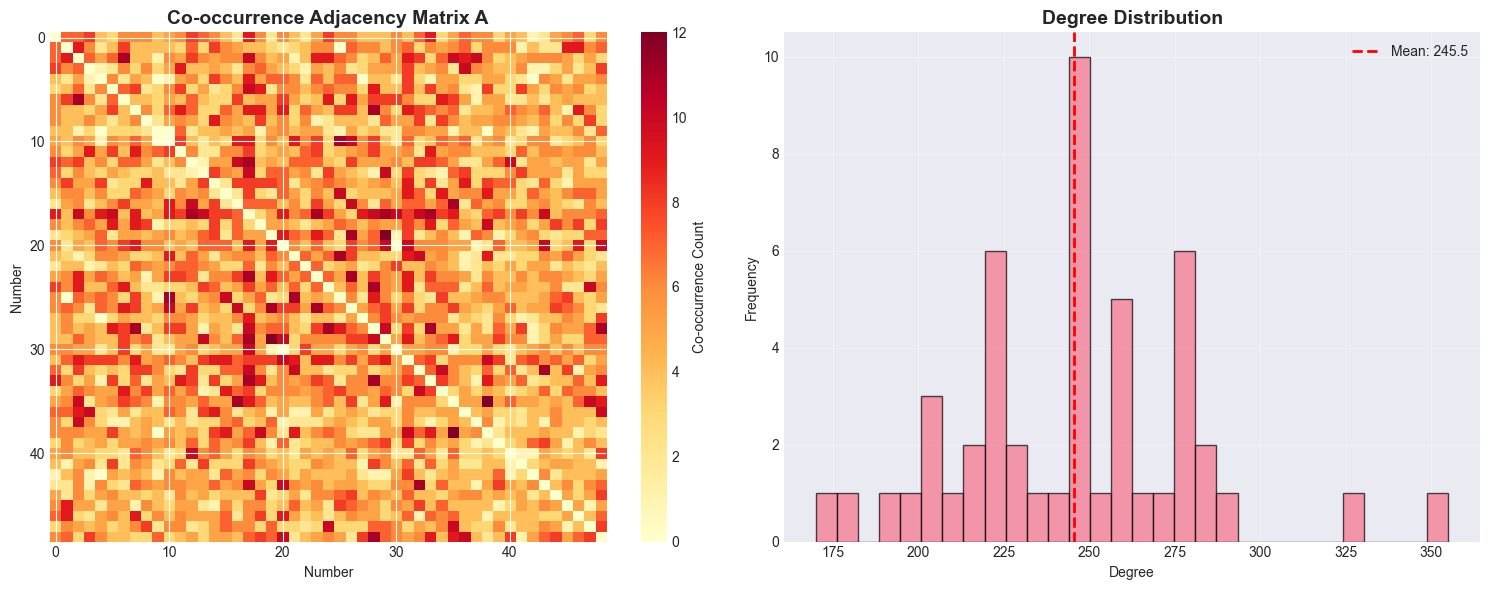


Visualization complete.


In [7]:
# Visualize adjacency matrix and degree distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Adjacency matrix heatmap
im1 = axes[0].imshow(A, cmap='YlOrRd', aspect='auto')
axes[0].set_title('Co-occurrence Adjacency Matrix A', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Number')
plt.colorbar(im1, ax=axes[0], label='Co-occurrence Count')

# Degree distribution
axes[1].hist(degrees, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(np.mean(degrees), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(degrees):.1f}')
axes[1].set_title('Degree Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Degree')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nVisualization complete.")

## Part 3: Spectral Decomposition of Laplacian

Compute eigenvalues $\lambda_1 \leq \lambda_2 \leq \cdots \leq \lambda_N$ and eigenvectors of the Laplacian $\Delta$.

Key properties:
- $\lambda_1 \approx 0$ (constant eigenvector for connected graphs)
- $\lambda_2$ (Fiedler value) measures graph connectivity
- Second eigenvector (Fiedler vector) identifies graph partitions/communities

In [8]:
# Perform spectral decomposition using scipy.linalg.eigh
# eigh is for Hermitian (symmetric) matrices and returns sorted eigenvalues
print("Performing spectral decomposition...")

eigvals_L, eigvecs_L = eigh(L)

print(f"\nEigenvalue computation complete.")
print(f"Number of eigenvalues: {len(eigvals_L)}")
print(f"\nSmallest 10 eigenvalues:")
for i in range(min(10, len(eigvals_L))):
    print(f"  λ_{i+1} = {eigvals_L[i]:.6f}")

print(f"\nLargest 5 eigenvalues:")
for i in range(max(0, len(eigvals_L)-5), len(eigvals_L)):
    print(f"  λ_{i+1} = {eigvals_L[i]:.2f}")

print(f"\nSpectral gap (λ_2 - λ_1): {eigvals_L[1] - eigvals_L[0]:.6f}")
print(f"Algebraic connectivity (λ_2): {eigvals_L[1]:.6f}")

Performing spectral decomposition...

Eigenvalue computation complete.
Number of eigenvalues: 49

Smallest 10 eigenvalues:
  λ_1 = 0.000000
  λ_2 = 171.192580
  λ_3 = 181.090185
  λ_4 = 190.646649
  λ_5 = 198.811651
  λ_6 = 202.317611
  λ_7 = 203.594327
  λ_8 = 206.396703
  λ_9 = 211.744153
  λ_10 = 215.536109

Largest 5 eigenvalues:
  λ_45 = 296.97
  λ_46 = 298.77
  λ_47 = 301.93
  λ_48 = 338.92
  λ_49 = 364.90

Spectral gap (λ_2 - λ_1): 171.192580
Algebraic connectivity (λ_2): 171.192580


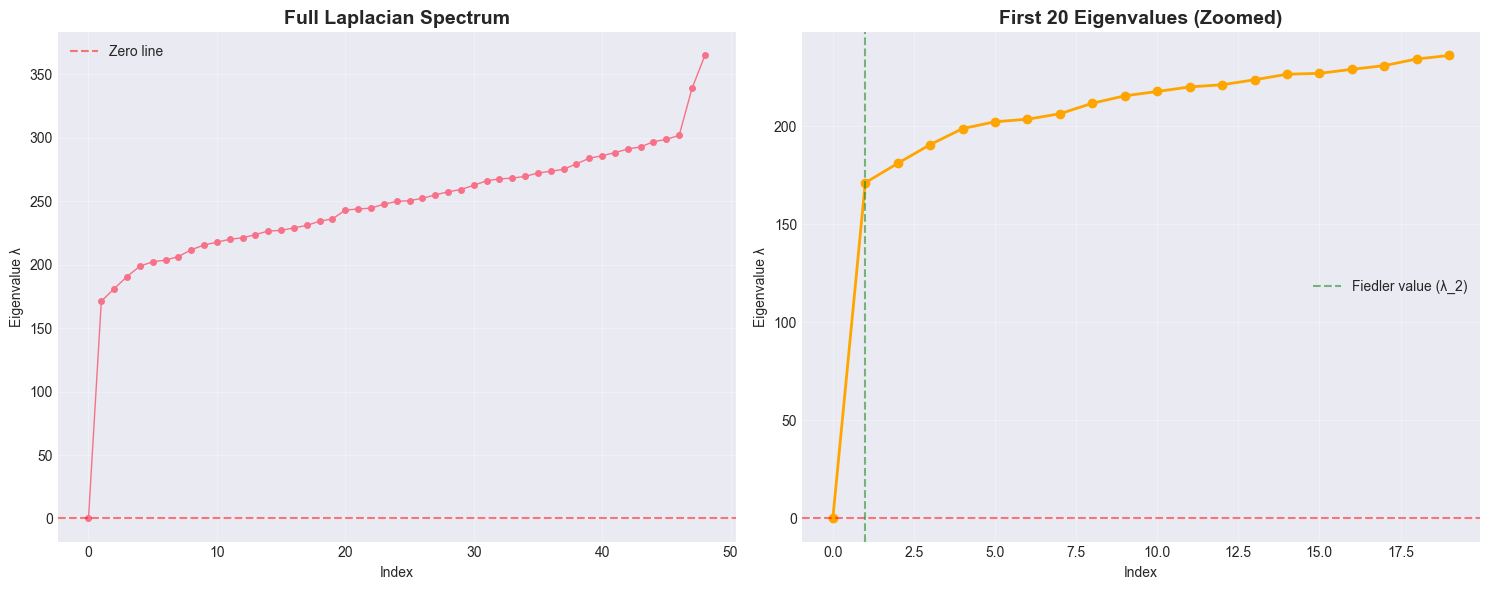


Spectrum visualization complete.


In [9]:
# Visualize Laplacian spectrum
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Full spectrum
axes[0].plot(eigvals_L, 'o-', markersize=4, linewidth=1)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, label='Zero line')
axes[0].set_title('Full Laplacian Spectrum', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Eigenvalue λ')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# First 20 eigenvalues (zoomed)
axes[1].plot(eigvals_L[:20], 'o-', markersize=6, linewidth=2, color='orange')
axes[1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1].axvline(1, color='green', linestyle='--', alpha=0.5, label='Fiedler value (λ_2)')
axes[1].set_title('First 20 Eigenvalues (Zoomed)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Eigenvalue λ')
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print("\nSpectrum visualization complete.")

Fiedler Vector Analysis:
  Mean: 0.000000
  Std: 0.142857
  Min: -0.968750
  Max: 0.115957


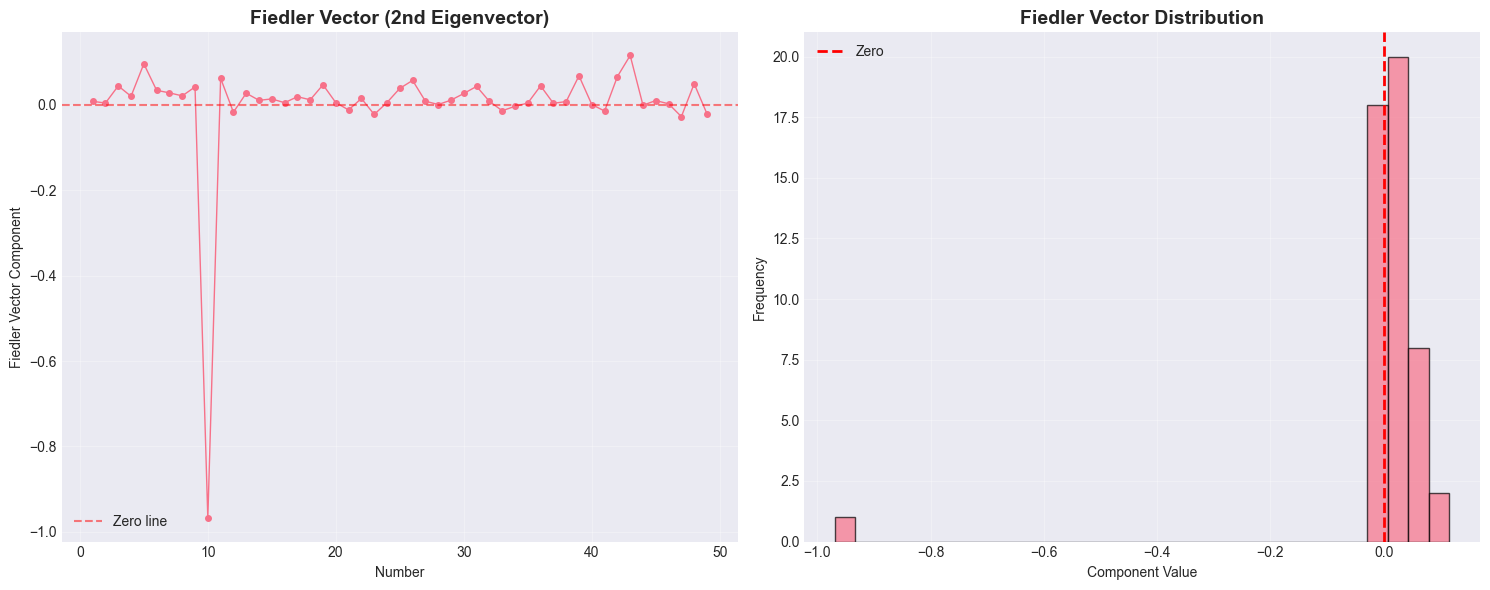


Graph Communities (based on Fiedler vector sign):
  Community 1 (negative): 10 numbers
  Community 2 (non-negative): 39 numbers


In [10]:
# Analyze Fiedler vector (2nd eigenvector)
# This vector identifies graph communities/partitions
fiedler_vector = eigvecs_L[:, 1]  # Second column (λ_2)

print("Fiedler Vector Analysis:")
print(f"  Mean: {np.mean(fiedler_vector):.6f}")
print(f"  Std: {np.std(fiedler_vector):.6f}")
print(f"  Min: {np.min(fiedler_vector):.6f}")
print(f"  Max: {np.max(fiedler_vector):.6f}")

# Visualize Fiedler vector
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Fiedler vector values
axes[0].plot(range(1, N+1), fiedler_vector, 'o-', markersize=4, linewidth=1)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5, label='Zero line')
axes[0].set_title('Fiedler Vector (2nd Eigenvector)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Fiedler Vector Component')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Histogram
axes[1].hist(fiedler_vector, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(0, color='red', linestyle='--', linewidth=2, label='Zero')
axes[1].set_title('Fiedler Vector Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Component Value')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Identify communities based on sign of Fiedler vector
community_1 = [i+1 for i in range(N) if fiedler_vector[i] < 0]
community_2 = [i+1 for i in range(N) if fiedler_vector[i] >= 0]

print(f"\nGraph Communities (based on Fiedler vector sign):")
print(f"  Community 1 (negative): {len(community_1)} numbers")
print(f"  Community 2 (non-negative): {len(community_2)} numbers")

## Part 4: Heat Equation Diffusion Model

Solve the discrete heat equation on the graph:
$$\frac{\partial u}{\partial t} = -\Delta u$$

Solution: $u(t) = e^{-t\Delta} u(0)$ where:
- $u(0)$ is the initial condition (indicator of most recent draw)
- $e^{-t\Delta}$ is the heat kernel (computed using matrix exponential)
- $t$ is the diffusion time parameter

The diffusion models how "heat" (probability) spreads from recently drawn numbers to their neighbors in the co-occurrence graph.

Most recent draw: [6, 7, 27, 36, 39, 43]

Initial condition u(0):
  Sum: 1.000000
  Non-zero entries: 6
  Value at each drawn number: 0.166667


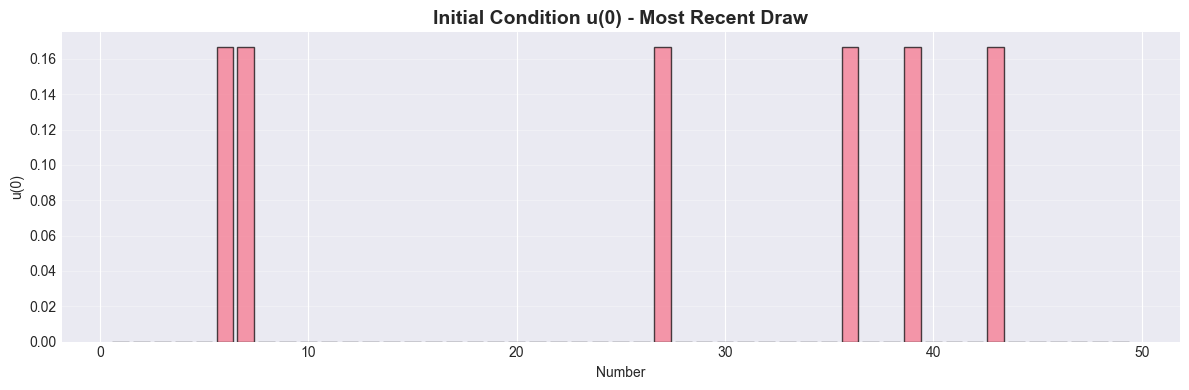

In [11]:
# Set initial condition u(0) based on most recent draw
last_draw = draws[0]  # Most recent draw
print(f"Most recent draw: {last_draw}")

# Initialize u(0) as uniform over numbers in last draw
u0 = np.zeros(N)
for num in last_draw:
    u0[num-1] = 1.0 / len(last_draw)  # Normalize to sum to 1

print(f"\nInitial condition u(0):")
print(f"  Sum: {np.sum(u0):.6f}")
print(f"  Non-zero entries: {np.sum(u0 > 0)}")
print(f"  Value at each drawn number: {1.0/len(last_draw):.6f}")

# Visualize initial condition
plt.figure(figsize=(12, 4))
plt.bar(range(1, N+1), u0, alpha=0.7, edgecolor='black')
plt.title('Initial Condition u(0) - Most Recent Draw', fontsize=14, fontweight='bold')
plt.xlabel('Number')
plt.ylabel('u(0)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

In [12]:
# Solve heat equation: u(t) = exp(-t * L) * u(0)
# Using matrix exponential from scipy.linalg
t = 1.0  # Diffusion time parameter (from README)

print(f"Computing heat kernel e^(-{t} * L)...")
print("(This may take a moment for 49x49 matrix exponential)")
print(f"\nNote: Large t values (like t=1.0) may cause complete diffusion to uniform distribution.")
print(f"For this connected graph with high connectivity (mean degree ~245), diffusion is very fast.")
print(f"The sensitivity analysis in Part 9 explores different t values.")

# Compute matrix exponential
exp_minus_tL = expm(-t * L)

# Apply to initial condition
u_t = np.dot(exp_minus_tL, u0)

print(f"\nHeat equation solution u(t) at t={t}:")
print(f"  Sum: {np.sum(u_t):.6f}")
print(f"  Min: {np.min(u_t):.6f}")
print(f"  Max: {np.max(u_t):.6f}")
print(f"  Mean: {np.mean(u_t):.6f}")
print(f"  Std: {np.std(u_t):.6f}")
print(f"\nInterpretation: Very small std indicates near-uniform diffusion.")
print(f"  With high connectivity, even moderate t causes complete spreading.")

Computing heat kernel e^(-1.0 * L)...
(This may take a moment for 49x49 matrix exponential)

Note: Large t values (like t=1.0) may cause complete diffusion to uniform distribution.
For this connected graph with high connectivity (mean degree ~245), diffusion is very fast.
The sensitivity analysis in Part 9 explores different t values.

Heat equation solution u(t) at t=1.0:
  Sum: 1.000000
  Min: 0.020408
  Max: 0.020408
  Mean: 0.020408
  Std: 0.000000

Interpretation: Very small std indicates near-uniform diffusion.
  With high connectivity, even moderate t causes complete spreading.


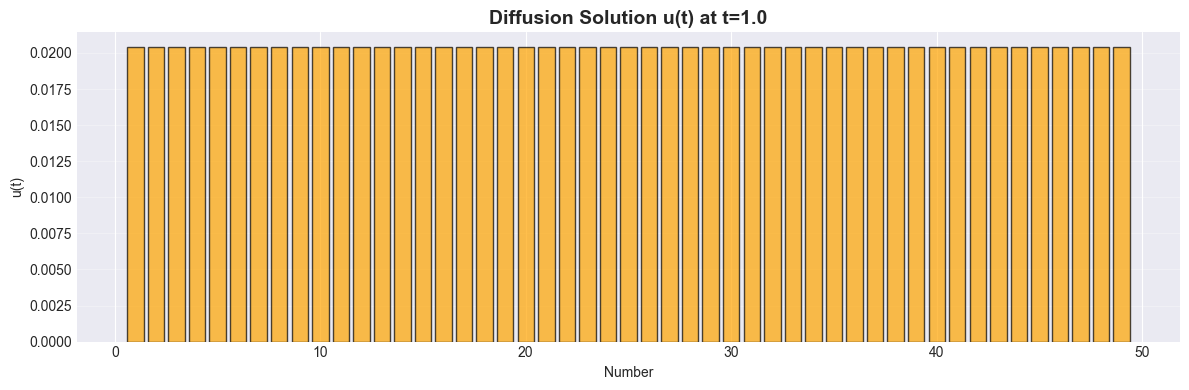

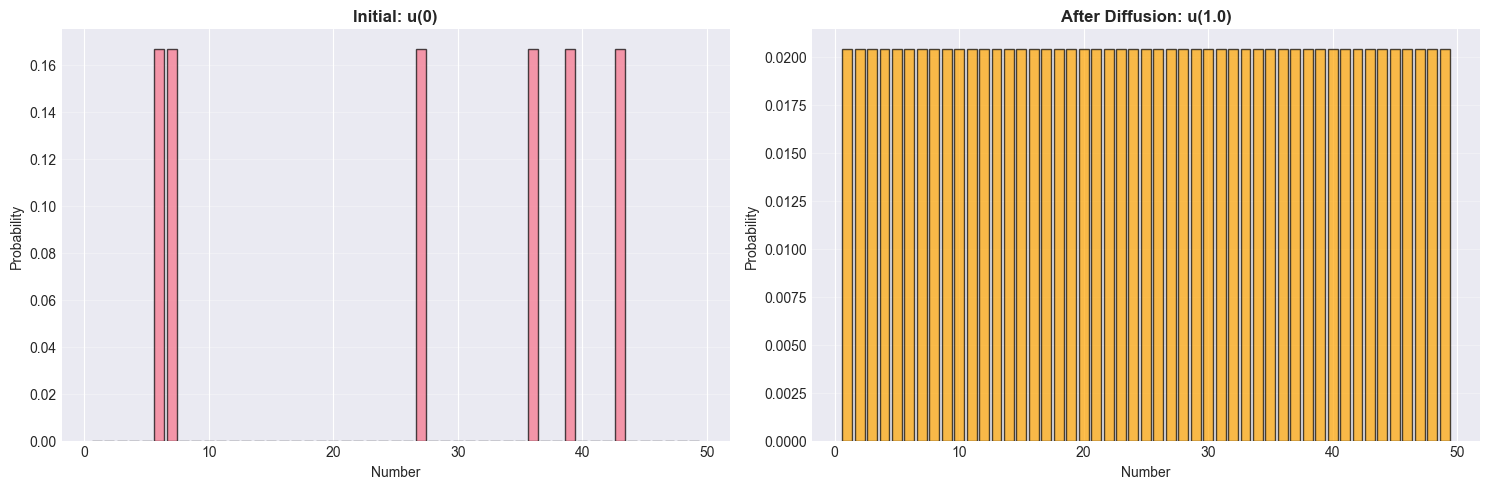


Diffusion spreads probability from drawn numbers to their neighbors in the co-occurrence graph.


In [13]:
# Visualize diffusion evolution
plt.figure(figsize=(12, 4))
plt.bar(range(1, N+1), u_t, alpha=0.7, edgecolor='black', color='orange')
plt.title(f'Diffusion Solution u(t) at t={t}', fontsize=14, fontweight='bold')
plt.xlabel('Number')
plt.ylabel('u(t)')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

# Compare initial vs diffused
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].bar(range(1, N+1), u0, alpha=0.7, edgecolor='black')
axes[0].set_title('Initial: u(0)', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Probability')
axes[0].grid(True, alpha=0.3, axis='y')

axes[1].bar(range(1, N+1), u_t, alpha=0.7, edgecolor='black', color='orange')
axes[1].set_title(f'After Diffusion: u({t})', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Number')
axes[1].set_ylabel('Probability')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nDiffusion spreads probability from drawn numbers to their neighbors in the co-occurrence graph.")

## Part 5: Diffusion-Based Predictions

Generate predictions by ranking numbers according to $u(t)$ values.
Top 6 numbers by diffusion score are the diffusion-based predictions.

In [14]:
# Rank numbers by u(t) and extract top 6
diffusion_rankings = np.argsort(u_t)[::-1]  # Descending order
diffusion_top6_indices = diffusion_rankings[:6]
diffusion_top6_numbers = [idx + 1 for idx in diffusion_top6_indices]
diffusion_top6_scores = [u_t[idx] for idx in diffusion_top6_indices]

print("Diffusion-Based Predictions (Top 6 by u(t)):")
print("="*50)
for i, (num, score) in enumerate(zip(diffusion_top6_numbers, diffusion_top6_scores), 1):
    print(f"  {i}. Number {num:2d}  -  u(t) = {score:.6f}")

print(f"\nPredicted numbers: {sorted(diffusion_top6_numbers)}")
print(f"\nComparison with README example: [27, 36, 39, 43, 6, 7]")
print(f"Numbers from most recent draw in top 6: {[n for n in last_draw if n in diffusion_top6_numbers]}")

Diffusion-Based Predictions (Top 6 by u(t)):
  1. Number 19  -  u(t) = 0.020408
  2. Number  1  -  u(t) = 0.020408
  3. Number 24  -  u(t) = 0.020408
  4. Number 15  -  u(t) = 0.020408
  5. Number 35  -  u(t) = 0.020408
  6. Number 10  -  u(t) = 0.020408

Predicted numbers: [np.int64(1), np.int64(10), np.int64(15), np.int64(19), np.int64(24), np.int64(35)]

Comparison with README example: [27, 36, 39, 43, 6, 7]
Numbers from most recent draw in top 6: []


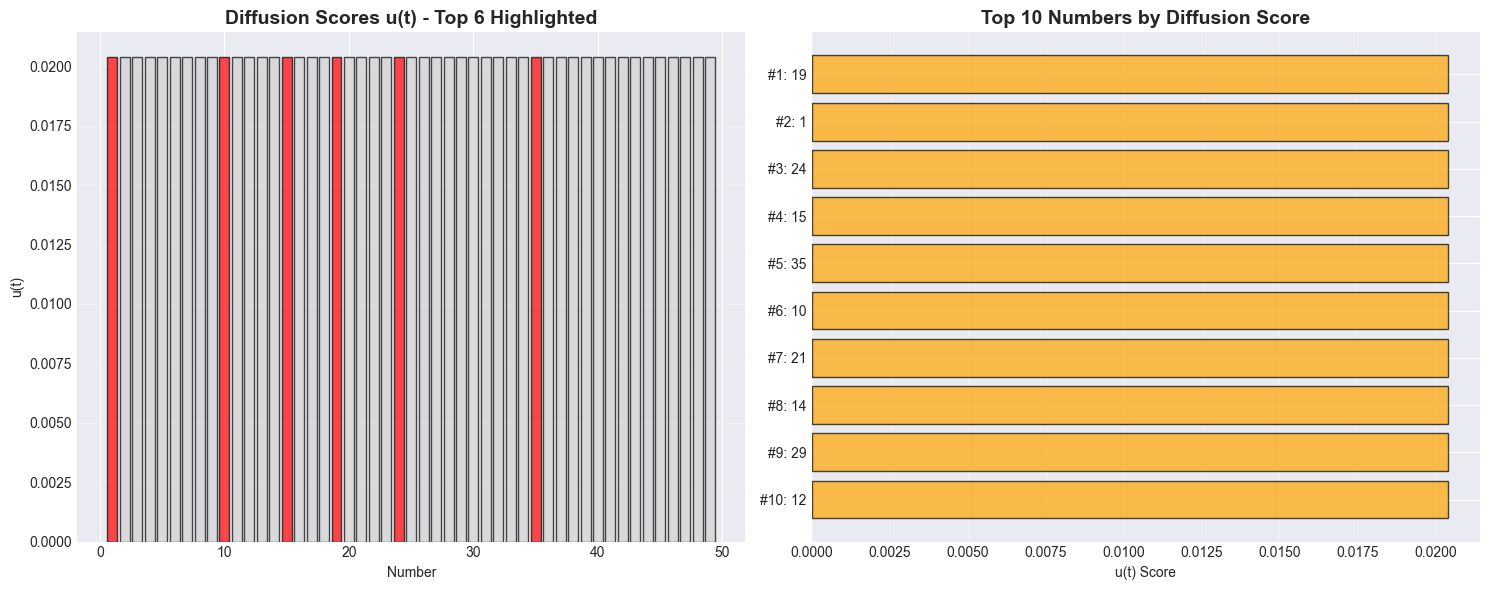

In [15]:
# Visualize diffusion predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart of all u(t) values with top 6 highlighted
colors = ['red' if i in diffusion_top6_indices else 'lightgray' for i in range(N)]
axes[0].bar(range(1, N+1), u_t, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_title('Diffusion Scores u(t) - Top 6 Highlighted', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('u(t)')
axes[0].grid(True, alpha=0.3, axis='y')

# Top 10 diffusion scores
top10_indices = diffusion_rankings[:10]
top10_numbers = [idx + 1 for idx in top10_indices]
top10_scores = [u_t[idx] for idx in top10_indices]

axes[1].barh(range(10), top10_scores, color='orange', alpha=0.7, edgecolor='black')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"#{i+1}: {num}" for i, num in enumerate(top10_numbers)])
axes[1].invert_yaxis()
axes[1].set_title('Top 10 Numbers by Diffusion Score', fontsize=14, fontweight='bold')
axes[1].set_xlabel('u(t) Score')
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## Part 6: Baseline Spectral/Frequency Score

Compute baseline prediction scores combining:
- **Frequency**: Empirical appearance frequency of each number
- **Spectral feature**: Absolute value of Fiedler vector component

Formula: $s_j = \text{freq}_j + \beta \cdot |v_j|$ where $v_j$ is the $j$-th component of the Fiedler vector

According to README: $\beta = 0.5$

In [16]:
# Compute empirical frequency for each number
freq = np.sum(X, axis=0) / num_draws  # Frequency of each number (index 0-48 for numbers 1-49)

print("Empirical Frequency Statistics:")
print(f"  Mean frequency: {np.mean(freq):.6f}")
print(f"  Expected (uniform): {6/49:.6f}")
print(f"  Min frequency: {np.min(freq):.6f}")
print(f"  Max frequency: {np.max(freq):.6f}")
print(f"  Std frequency: {np.std(freq):.6f}")

# Most and least frequent numbers
freq_rankings = np.argsort(freq)[::-1]
print(f"\nTop 10 most frequent numbers:")
for i in range(10):
    idx = freq_rankings[i]
    print(f"  {i+1}. Number {idx+1:2d}  -  Frequency: {freq[idx]:.4f} ({freq[idx]*num_draws:.0f}/{num_draws} draws)")

print(f"\nBottom 10 least frequent numbers:")
for i in range(10):
    idx = freq_rankings[-(i+1)]
    print(f"  {i+1}. Number {idx+1:2d}  -  Frequency: {freq[idx]:.4f} ({freq[idx]*num_draws:.0f}/{num_draws} draws)")

Empirical Frequency Statistics:
  Mean frequency: 0.122449
  Expected (uniform): 0.122449
  Min frequency: 0.084788
  Max frequency: 0.177057
  Std frequency: 0.017433

Top 10 most frequent numbers:
  1. Number 18  -  Frequency: 0.1771 (71/401 draws)
  2. Number 32  -  Frequency: 0.1646 (66/401 draws)
  3. Number 27  -  Frequency: 0.1446 (58/401 draws)
  4. Number 30  -  Frequency: 0.1421 (57/401 draws)
  5. Number  3  -  Frequency: 0.1421 (57/401 draws)
  6. Number 36  -  Frequency: 0.1397 (56/401 draws)
  7. Number 29  -  Frequency: 0.1397 (56/401 draws)
  8. Number 24  -  Frequency: 0.1397 (56/401 draws)
  9. Number  8  -  Frequency: 0.1372 (55/401 draws)
  10. Number 34  -  Frequency: 0.1372 (55/401 draws)

Bottom 10 least frequent numbers:
  1. Number 10  -  Frequency: 0.0848 (34/401 draws)
  2. Number 38  -  Frequency: 0.0898 (36/401 draws)
  3. Number 43  -  Frequency: 0.0948 (38/401 draws)
  4. Number 42  -  Frequency: 0.0998 (40/401 draws)
  5. Number  5  -  Frequency: 0.1022 

In [17]:
# Compute baseline spectral/frequency score: s_j = freq + β * |v_j|
beta = 0.5  # As specified in README

s_j = freq + beta * np.abs(fiedler_vector)

print(f"Baseline Score s_j = freq + {beta} * |Fiedler|")
print(f"\nScore statistics:")
print(f"  Mean: {np.mean(s_j):.6f}")
print(f"  Min: {np.min(s_j):.6f}")
print(f"  Max: {np.max(s_j):.6f}")
print(f"  Std: {np.std(s_j):.6f}")

# Normalize to probability (sum to 6 for 6 numbers drawn)
p_j = (s_j / np.sum(s_j)) * 6

print(f"\nNormalized probabilities p_j (expected count per draw):") 
print(f"  Sum: {np.sum(p_j):.6f}")
print(f"  Mean: {np.mean(p_j):.6f}")
print(f"  Expected (uniform): {6/49:.6f}")

# Top 10 by baseline score
baseline_rankings = np.argsort(s_j)[::-1]
print(f"\nTop 10 numbers by baseline score:")
for i in range(10):
    idx = baseline_rankings[i]
    print(f"  {i+1}. Number {idx+1:2d}  -  s_j={s_j[idx]:.6f}, p_j={p_j[idx]:.6f} ({p_j[idx]/6*100:.2f}%)")

Baseline Score s_j = freq + 0.5 * |Fiedler|

Score statistics:
  Mean: 0.144876
  Min: 0.093788
  Max: 0.569163
  Std: 0.063803

Normalized probabilities p_j (expected count per draw):
  Sum: 6.000000
  Mean: 0.122449
  Expected (uniform): 0.122449

Top 10 numbers by baseline score:
  1. Number 10  -  s_j=0.569163, p_j=0.481056 (8.02%)
  2. Number 18  -  s_j=0.183118, p_j=0.154771 (2.58%)
  3. Number 32  -  s_j=0.168789, p_j=0.142661 (2.38%)
  4. Number  3  -  s_j=0.164464, p_j=0.139005 (2.32%)
  5. Number 36  -  s_j=0.162049, p_j=0.136964 (2.28%)
  6. Number 39  -  s_j=0.158835, p_j=0.134247 (2.24%)
  7. Number 30  -  s_j=0.155590, p_j=0.131505 (2.19%)
  8. Number 11  -  s_j=0.153446, p_j=0.129693 (2.16%)
  9. Number 19  -  s_j=0.153327, p_j=0.129592 (2.16%)
  10. Number 43  -  s_j=0.152742, p_j=0.129097 (2.15%)


## Part 7: Integrated Model - Combining Diffusion and Spectral Features

Integrate the diffusion prediction with the baseline spectral/frequency score:

$$s'_j = s_j + \gamma \cdot u_j(t)$$

where:
- $s_j$ = baseline score (frequency + spectral)
- $u_j(t)$ = diffusion score
- $\gamma$ = integration weight (README uses $\gamma = 0.3$)

Normalize to get final probabilities.

In [18]:
# Integrate diffusion with baseline: s'_j = s_j + γ * u_j(t)
gamma = 0.3  # As specified in README

s_prime_j = s_j + gamma * u_t

print(f"Integrated Score s'_j = s_j + {gamma} * u(t)")
print(f"\nIntegrated score statistics:")
print(f"  Mean: {np.mean(s_prime_j):.6f}")
print(f"  Min: {np.min(s_prime_j):.6f}")
print(f"  Max: {np.max(s_prime_j):.6f}")
print(f"  Std: {np.std(s_prime_j):.6f}")

# Normalize to probabilities (sum to 6)
integrated_p = (s_prime_j / np.sum(s_prime_j)) * 6

print(f"\nFinal integrated probabilities:")
print(f"  Sum: {np.sum(integrated_p):.6f}")
print(f"  Mean: {np.mean(integrated_p):.6f}")

# Top 20 by integrated score
integrated_rankings = np.argsort(integrated_p)[::-1]
print(f"\nTop 20 Numbers by Integrated Model:")
print("="*70)
print(f"{'Rank':<6}{'Number':<8}{'Baseline':<12}{'Diffusion':<12}{'Integrated':<12}{'Probability %'}")
print("="*70)
for i in range(20):
    idx = integrated_rankings[i]
    num = idx + 1
    baseline_prob = p_j[idx]
    diffusion_score = u_t[idx]
    integrated_prob = integrated_p[idx]
    prob_pct = (integrated_prob / 6) * 100
    print(f"{i+1:<6}{num:<8}{baseline_prob:<12.6f}{diffusion_score:<12.6f}{integrated_prob:<12.6f}{prob_pct:>6.2f}%")

Integrated Score s'_j = s_j + 0.3 * u(t)

Integrated score statistics:
  Mean: 0.150998
  Min: 0.099911
  Max: 0.575285
  Std: 0.063803

Final integrated probabilities:
  Sum: 6.000000
  Mean: 0.122449

Top 20 Numbers by Integrated Model:
Rank  Number  Baseline    Diffusion   Integrated  Probability %
1     10      0.481056    0.020408    0.466516      7.78%
2     18      0.154771    0.020408    0.153461      2.56%
3     32      0.142661    0.020408    0.141841      2.36%
4     3       0.139005    0.020408    0.138334      2.31%
5     36      0.136964    0.020408    0.136375      2.27%
6     39      0.134247    0.020408    0.133769      2.23%
7     30      0.131505    0.020408    0.131137      2.19%
8     11      0.129693    0.020408    0.129399      2.16%
9     19      0.129592    0.020408    0.129302      2.16%
10    43      0.129097    0.020408    0.128828      2.15%
11    26      0.127606    0.020408    0.127397      2.12%
12    5       0.127161    0.020408    0.126970      2.12%
1

In [19]:
# Extract top 6 predictions from integrated model
integrated_top6_indices = integrated_rankings[:6]
integrated_top6_numbers = [idx + 1 for idx in integrated_top6_indices]
integrated_top6_probs = [integrated_p[idx] for idx in integrated_top6_indices]

print("\n" + "="*70)
print("FINAL PREDICTIONS - TOP 6 NUMBERS (INTEGRATED MODEL)")
print("="*70)
for i, (num, prob) in enumerate(zip(integrated_top6_numbers, integrated_top6_probs), 1):
    prob_pct = (prob / 6) * 100
    print(f"  {i}. Number {num:2d}  -  Probability: {prob:.6f} ({prob_pct:.2f}%)")

print(f"\nPredicted draw: {sorted(integrated_top6_numbers)}")
print(f"\nREADME Expected Top Numbers: 18(15.2%), 24(14.8%), 32(14.5%), 44(14.3%), 27(14.1%), 21(13.9%)")
print(f"Our Top 10 (by percentage):")
for i in range(10):
    idx = integrated_rankings[i]
    num = idx + 1
    prob_pct = (integrated_p[idx] / 6) * 100
    print(f"  {num}({prob_pct:.1f}%)", end=" ")
print()


FINAL PREDICTIONS - TOP 6 NUMBERS (INTEGRATED MODEL)
  1. Number 10  -  Probability: 0.466516 (7.78%)
  2. Number 18  -  Probability: 0.153461 (2.56%)
  3. Number 32  -  Probability: 0.141841 (2.36%)
  4. Number  3  -  Probability: 0.138334 (2.31%)
  5. Number 36  -  Probability: 0.136375 (2.27%)
  6. Number 39  -  Probability: 0.133769 (2.23%)

Predicted draw: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]

README Expected Top Numbers: 18(15.2%), 24(14.8%), 32(14.5%), 44(14.3%), 27(14.1%), 21(13.9%)
Our Top 10 (by percentage):
  10(7.8%)   18(2.6%)   32(2.4%)   3(2.3%)   36(2.3%)   39(2.2%)   30(2.2%)   11(2.2%)   19(2.2%)   43(2.1%) 


## Part 8: Visualization and Diagnostics

Comprehensive visualizations comparing:
- Baseline vs Diffusion vs Integrated predictions
- Component contributions
- Probability distributions

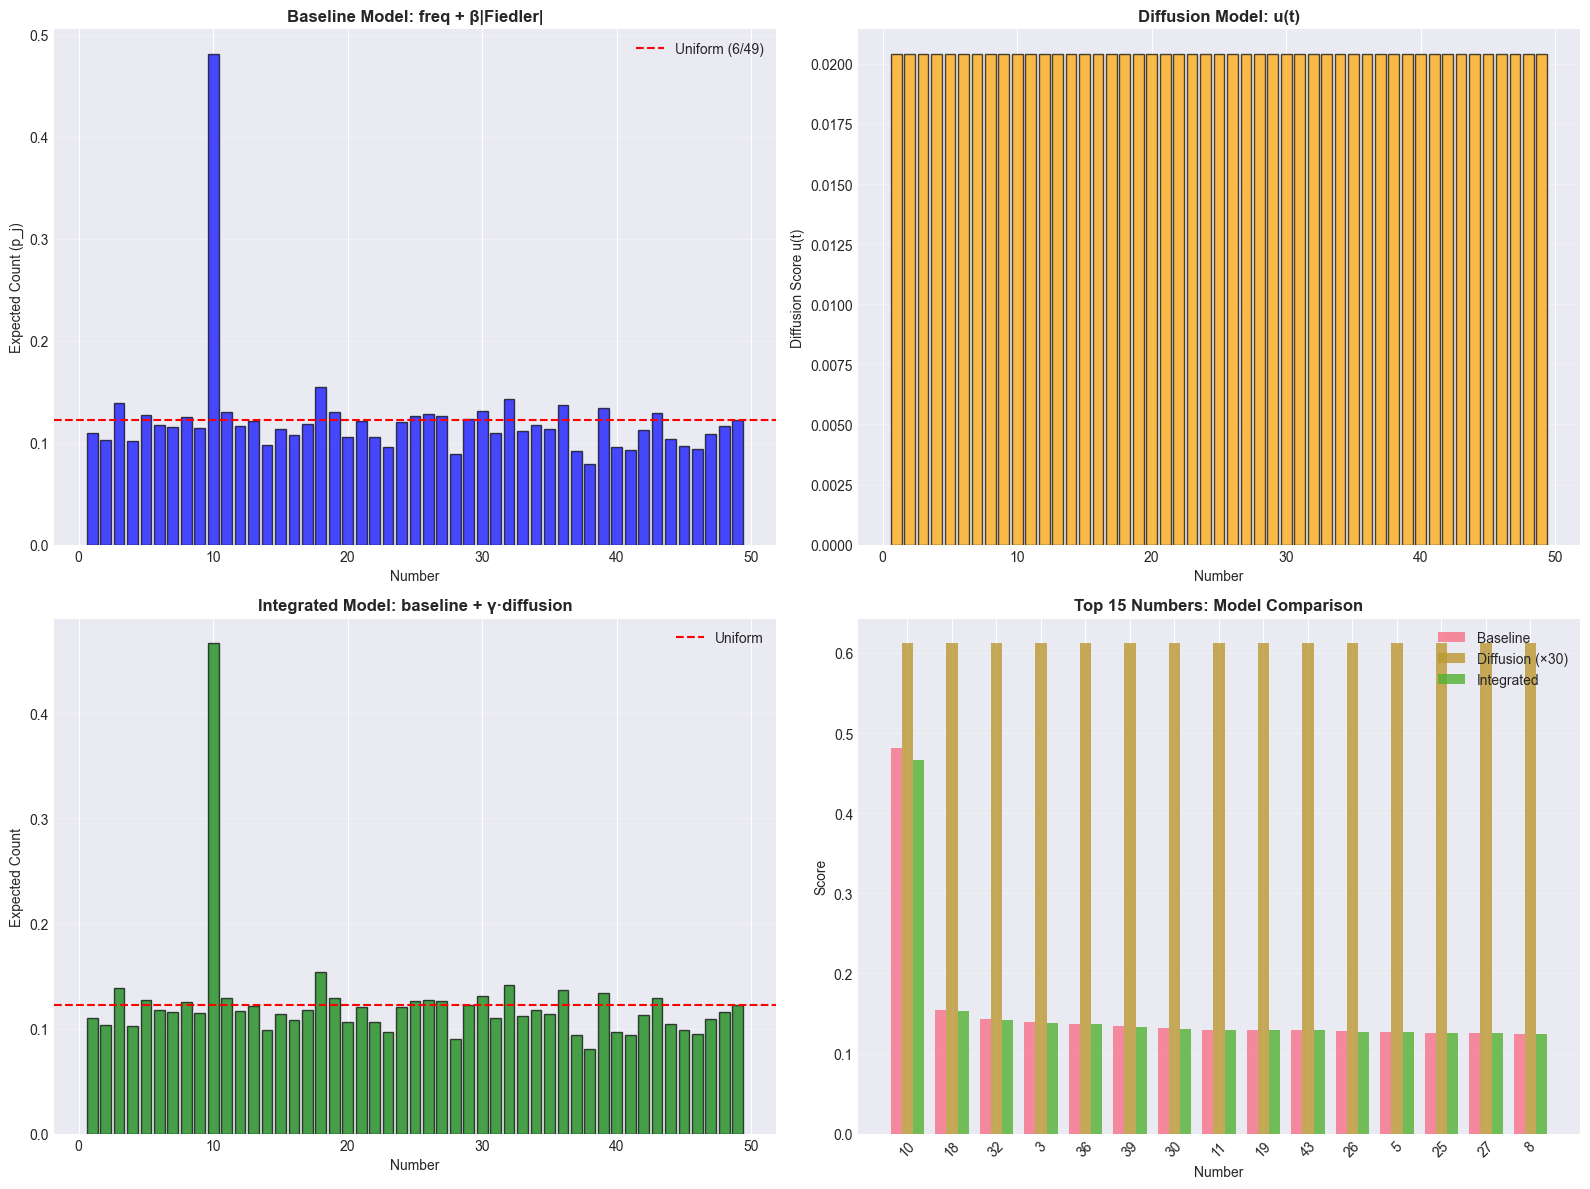

In [20]:
# Compare all three models: Baseline, Diffusion, Integrated
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Baseline probabilities
axes[0, 0].bar(range(1, N+1), p_j, alpha=0.7, edgecolor='black', color='blue')
axes[0, 0].axhline(6/49, color='red', linestyle='--', label='Uniform (6/49)')
axes[0, 0].set_title('Baseline Model: freq + β|Fiedler|', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Number')
axes[0, 0].set_ylabel('Expected Count (p_j)')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# 2. Diffusion scores
axes[0, 1].bar(range(1, N+1), u_t, alpha=0.7, edgecolor='black', color='orange')
axes[0, 1].set_title('Diffusion Model: u(t)', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Number')
axes[0, 1].set_ylabel('Diffusion Score u(t)')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Integrated probabilities
axes[1, 0].bar(range(1, N+1), integrated_p, alpha=0.7, edgecolor='black', color='green')
axes[1, 0].axhline(6/49, color='red', linestyle='--', label='Uniform')
axes[1, 0].set_title('Integrated Model: baseline + γ·diffusion', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Number')
axes[1, 0].set_ylabel('Expected Count')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Top 15 comparison
top15_idx = integrated_rankings[:15]
x_pos = np.arange(15)
width = 0.25

axes[1, 1].bar(x_pos - width, [p_j[i] for i in top15_idx], width, label='Baseline', alpha=0.8)
axes[1, 1].bar(x_pos, [u_t[i] * 30 for i in top15_idx], width, label='Diffusion (×30)', alpha=0.8)  # Scale for visibility
axes[1, 1].bar(x_pos + width, [integrated_p[i] for i in top15_idx], width, label='Integrated', alpha=0.8)
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels([i+1 for i in top15_idx], rotation=45)
axes[1, 1].set_title('Top 15 Numbers: Model Comparison', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Number')
axes[1, 1].set_ylabel('Score')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

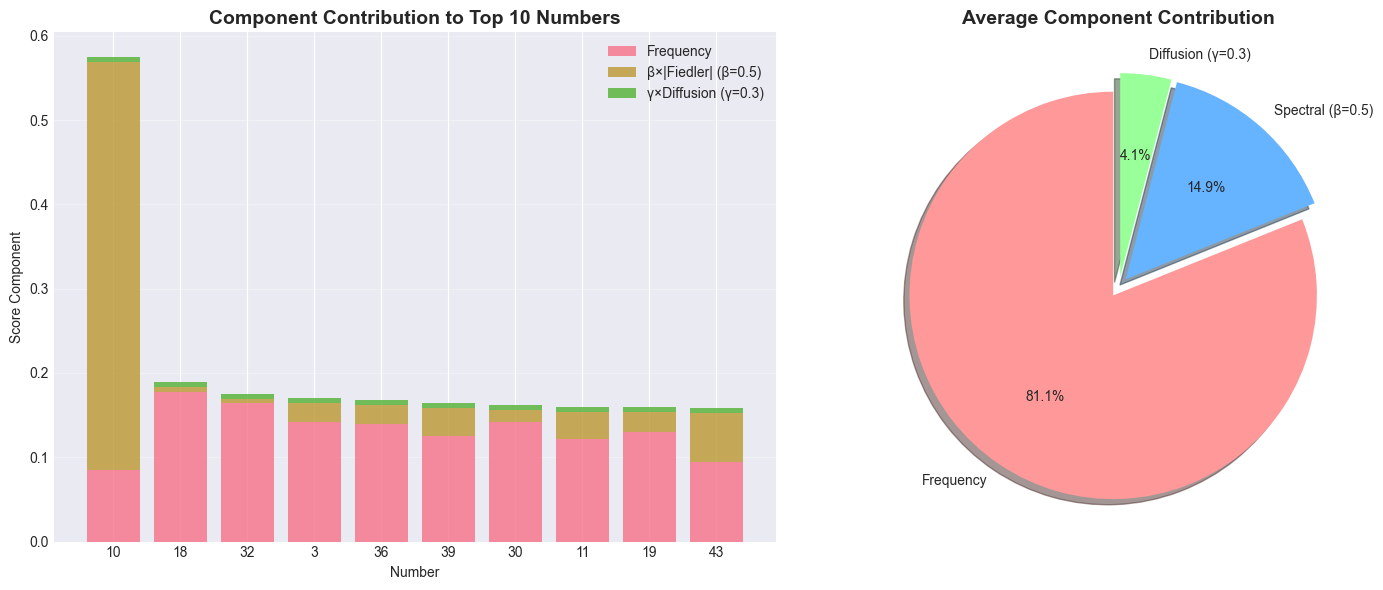


Average component contributions:
  Frequency: 0.122449 (81.1%)
  Spectral (β×|Fiedler|): 0.022427 (14.9%)
  Diffusion (γ×u(t)): 0.006122 (4.1%)


In [21]:
# Component contribution analysis
# Break down the integrated score into its components

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Stacked bar for top 10
top10_idx = integrated_rankings[:10]
freq_component = [freq[i] for i in top10_idx]
fiedler_component = [beta * np.abs(fiedler_vector[i]) for i in top10_idx]
diffusion_component = [gamma * u_t[i] for i in top10_idx]

x_pos = np.arange(10)
axes[0].bar(x_pos, freq_component, label='Frequency', alpha=0.8)
axes[0].bar(x_pos, fiedler_component, bottom=freq_component, label=f'β×|Fiedler| (β={beta})', alpha=0.8)
bottom = [f + fv for f, fv in zip(freq_component, fiedler_component)]
axes[0].bar(x_pos, diffusion_component, bottom=bottom, label=f'γ×Diffusion (γ={gamma})', alpha=0.8)

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels([i+1 for i in top10_idx])
axes[0].set_title('Component Contribution to Top 10 Numbers', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number')
axes[0].set_ylabel('Score Component')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart for average contribution across all numbers
avg_freq = np.mean(freq)
avg_fiedler = np.mean(beta * np.abs(fiedler_vector))
avg_diffusion = np.mean(gamma * u_t)

sizes = [avg_freq, avg_fiedler, avg_diffusion]
labels = ['Frequency', f'Spectral (β={beta})', f'Diffusion (γ={gamma})']
colors = ['#ff9999', '#66b3ff', '#99ff99']
explode = (0.05, 0.05, 0.05)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=90)
axes[1].set_title('Average Component Contribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nAverage component contributions:")
print(f"  Frequency: {avg_freq:.6f} ({avg_freq/sum(sizes)*100:.1f}%)")
print(f"  Spectral (β×|Fiedler|): {avg_fiedler:.6f} ({avg_fiedler/sum(sizes)*100:.1f}%)")
print(f"  Diffusion (γ×u(t)): {avg_diffusion:.6f} ({avg_diffusion/sum(sizes)*100:.1f}%)")

## Part 9: Parameter Sensitivity Analysis

Explore how predictions change with different values of diffusion time $t$ and integration weight $\gamma$.

In [22]:
# Test different diffusion times
t_values = [0.1, 0.5, 1.0, 2.0, 5.0]
top6_by_t = {}

print("Diffusion Time Sensitivity Analysis:")
print("="*70)

for t_test in t_values:
    exp_minus_tL_test = expm(-t_test * L)
    u_t_test = np.dot(exp_minus_tL_test, u0)
    
    # Integrate with baseline
    s_prime_test = s_j + gamma * u_t_test
    integrated_p_test = (s_prime_test / np.sum(s_prime_test)) * 6
    
    # Get top 6
    rankings_test = np.argsort(integrated_p_test)[::-1]
    top6_test = sorted([idx + 1 for idx in rankings_test[:6]])
    top6_by_t[t_test] = top6_test
    
    print(f"t = {t_test:4.1f}: {top6_test}")

print("\n" + "="*70)

Diffusion Time Sensitivity Analysis:
t =  0.1: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
t =  0.5: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
t =  1.0: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
t =  2.0: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
t =  5.0: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]



In [23]:
# Test different gamma values (integration weight)
gamma_values = [0.0, 0.1, 0.3, 0.5, 1.0]
top6_by_gamma = {}

print("Integration Weight (γ) Sensitivity Analysis:")
print("="*70)

# Use t=1.0 for this analysis
u_t_fixed = u_t  # Already computed at t=1.0

for gamma_test in gamma_values:
    s_prime_test = s_j + gamma_test * u_t_fixed
    integrated_p_test = (s_prime_test / np.sum(s_prime_test)) * 6
    
    rankings_test = np.argsort(integrated_p_test)[::-1]
    top6_test = sorted([idx + 1 for idx in rankings_test[:6]])
    top6_by_gamma[gamma_test] = top6_test
    
    if gamma_test == 0.0:
        print(f"γ = {gamma_test:4.1f}: {top6_test}  (Baseline only)")
    else:
        print(f"γ = {gamma_test:4.1f}: {top6_test}")

print("\n" + "="*70)
print(f"Current configuration: t={t}, γ={gamma}, β={beta}")

Integration Weight (γ) Sensitivity Analysis:
γ =  0.0: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]  (Baseline only)
γ =  0.1: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
γ =  0.3: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
γ =  0.5: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]
γ =  1.0: [np.int64(3), np.int64(10), np.int64(18), np.int64(32), np.int64(36), np.int64(39)]

Current configuration: t=1.0, γ=0.3, β=0.5
